## 📦 Imports et Utilitaires

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

## ÉTAPE 1: Amélioration de l'Encodage Textuel (X_t)

In [11]:
class TextEncoder(nn.Module):
    """
    Encodeur de texte enrichi utilisant un Transformer Encoder.
    Conserve les T=8 premiers tokens pour former X_t.
    """
    def __init__(self, hidden_dim=768, num_layers=2, num_heads=8, T=8):
        super(TextEncoder, self).__init__()
        self.T = T
        self.hidden_dim = hidden_dim

        # Token
        self.em_token = nn.Parameter(torch.randn(1, 1, hidden_dim))

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, bert_hidden_states):
        """
        Args:
            bert_hidden_states: [B, seq_len, hidden_dim] séquence brute de BERT
        Returns:
            X_t: [B, T, hidden_dim] séquence enrichie
        """
        batch_size = bert_hidden_states.size(0)

        # Ajouter le token spécial Em en tête
        em_expanded = self.em_token.expand(batch_size, -1, -1)
        sequence = torch.cat([em_expanded, bert_hidden_states], dim=1)

        # Appliquer le Transformer Encoder
        encoded_sequence = self.transformer_encoder(sequence)

        # Conserver uniquement les T premiers tokens
        X_t = encoded_sequence[:, :self.T, :]

        return X_t

## ÉTAPES 2 & 3: Descriptions Émotionnelles (D_a et D_v)

In [12]:
def extract_audio_features(audio_data_vector):
    """
    Extracts simplified audio features (Pitch, Loudness, Jitter, Shimmer)
    from a pre-extracted audio feature vector, with a more meaningful conceptual mapping.
    Args:
        audio_data_vector: tensor [B, audio_dim] of audio features.
    Returns:
        dict with the 4 values (tensors [B]).
    """
    batch_size = audio_data_vector.size(0)
    audio_dim = audio_data_vector.size(1)


    # Pitch: derived from mean of first 10 dimensions, normalized
    pitch = audio_data_vector[:, :min(10, audio_dim)].mean(dim=1).abs() / 2 + 0.2
    # Loudness: derived from mean of next 10 dimensions, normalized
    loudness = audio_data_vector[:, min(10, audio_dim):min(20, audio_dim)].mean(dim=1).abs() / 2 + 0.2
    # Jitter: derived from std dev of a segment, indicating variability
    jitter = audio_data_vector[:, min(20, audio_dim):min(30, audio_dim)].std(dim=1) * 0.1
    # Shimmer: derived from range of a segment
    shimmer = (audio_data_vector[:, min(30, audio_dim):min(40, audio_dim)].max(dim=1).values -
               audio_data_vector[:, min(30, audio_dim):min(40, audio_dim)].min(dim=1).values).abs() * 0.05

    # Clamp values to a reasonable range
    pitch = torch.clamp(pitch, 0.0, 1.0)
    loudness = torch.clamp(loudness, 0.0, 1.0)
    jitter = torch.clamp(jitter, 0.0, 0.5)
    shimmer = torch.clamp(shimmer, 0.0, 0.5)

    features = {
        'pitch': pitch.cpu().numpy(),
        'loudness': loudness.cpu().numpy(),
        'jitter': jitter.cpu().numpy(),
        'shimmer': shimmer.cpu().numpy()
    }
    return features


def audio_description(pitch, loudness, jitter, shimmer):
    """
    Generates a textual description of audio characteristics.
    Args:
        pitch, loudness, jitter, shimmer: scalar values
    Returns:
        str: descriptive sentence
    """
    pitch_level = "high" if pitch > 0.6 else ("low" if pitch < 0.4 else "normal")
    loudness_level = "loud" if loudness > 0.6 else ("soft" if loudness < 0.4 else "moderate")
    jitter_level = "unstable" if jitter > 0.2 else "stable"
    shimmer_level = "varying" if shimmer > 0.2 else "consistent"

    description = (f"The speaker used {pitch_level} pitch with {loudness_level} volume. "
                   f"The voice quality is {jitter_level} with {shimmer_level} intensity.")

    return description


def visual_description(visual_data_vector):
    """
    Generates a textual description of facial Action Units, with a more
    meaningful conceptual mapping from the simulated feature vector.
    Args:
        visual_data_vector: tensor [B, vision_dim] of visual features.
    Returns:
        str: descriptive sentence
    """
    au_meanings = {
        1: "raised inner brow", 2: "raised outer brow", 4: "lowered brow",
        5: "wide eyes", 6: "raised cheeks (smile)", 7: "tightened eyelids (joy/discomfort)",
        9: "wrinkled nose (disgust)", 12: "lip corners pulled (smile)", 15: "depressed lip corners (sadness)",
        17: "raised chin (contempt)", 20: "stretched lips", 25: "parted lips", 26: "jaw drop (surprise)"
    }

    if visual_data_vector.dim() == 1:
        visual_data_vector = visual_data_vector.unsqueeze(0)

    batch_size = visual_data_vector.size(0)
    vision_dim = visual_data_vector.size(1)

    descriptions_batch = []
    for i in range(batch_size):

        active_aus_indices = []


        if vision_dim >= 5:
            if visual_data_vector[i, 0:5].mean() > 0.6: active_aus_indices.append(6) # Cheek raiser (smile)
            if visual_data_vector[i, 5:10].mean() < -0.4: active_aus_indices.append(15) # Lip corner depressor (sadness)
            if visual_data_vector[i, 10:15].max() > 0.7: active_aus_indices.append(26) # Jaw drop (surprise)
            if visual_data_vector[i, 15:20].mean() > 0.5 and visual_data_vector[i, 20:25].mean() > 0.5: active_aus_indices.append(12) # Lip corner puller (smile)

        current_descriptions = [au_meanings[au] for au in active_aus_indices if au in au_meanings]

        if current_descriptions:
            description = "The person shows signs of: " + ", ".join(current_descriptions) + "."
        else:
            description = "The person shows a neutral facial expression."
        descriptions_batch.append(description)

    return descriptions_batch[0] if batch_size == 1 else descriptions_batch


class EmotionalDescriptionEncoder(nn.Module):
    """
    Encode les descriptions émotionnelles textuelles en embeddings.
    """
    def __init__(self, bert_model, text_encoder):
        super(EmotionalDescriptionEncoder, self).__init__()
        self.bert_model = bert_model
        self.text_encoder = text_encoder
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def forward(self, descriptions, device):
        """
        Args:
            descriptions: liste de strings
            device: torch device
        Returns:
            embeddings: [B, T, hidden_dim]
        """
        # Tokenize les descriptions
        encoded = self.tokenizer(
            descriptions,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)

        # Encoder avec BERT
        with torch.no_grad():
            bert_outputs = self.bert_model(**encoded)
            hidden_states = bert_outputs.last_hidden_state

        # Appliquer le TextEncoder
        embeddings = self.text_encoder(hidden_states)

        return embeddings

## ÉTAPE 4: Attention Croisée et MFU (Minor Fusion Unit)

In [13]:
class CrossModalAttention(nn.Module):
    """
    Attention Croisée Scaled Dot-Product pour la fusion text-guided.
    """
    def __init__(self, hidden_dim=768):
        super(CrossModalAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.scale = hidden_dim ** -0.5

        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.value_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, target_modality, text_guide):
        """
        Args:
            target_modality: [B, T, D] modalité à enrichir (Audio ou Vision)
            text_guide: [B, T, D] séquence textuelle X_t
        Returns:
            attended_features: [B, T, D] features enrichies
        """
        Q = self.query_proj(target_modality)
        K = self.key_proj(text_guide)
        V = self.value_proj(text_guide)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attention_weights = F.softmax(attention_scores, dim=-1)

        attended_features = torch.matmul(attention_weights, V)

        return attended_features


class MFU(nn.Module):
    """
    Minor Fusion Unit: fusion résiduelle text-guided avec attention croisée.
    Output = prev_fusion + α·Att_T→A(X_a, X_t) + β·Att_T→V(X_v, X_t)
    """
    def __init__(self, hidden_dim=768):
        super(MFU, self).__init__()

        # Modules d'attention croisée
        self.cross_attention_audio = CrossModalAttention(hidden_dim)
        self.cross_attention_vision = CrossModalAttention(hidden_dim)

        # Poids learnables α et β
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.beta = nn.Parameter(torch.tensor(0.5))

        # Layer Norm pour stabilité
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, prev_fusion, X_a, X_v, X_t):
        """
        Args:
            prev_fusion: [B, T, D] fusion précédente
            X_a: [B, T, D] séquence audio
            X_v: [B, T, D] séquence vision
            X_t: [B, T, D] séquence texte (guide)
        Returns:
            fused_output: [B, T, D] fusion enrichie
        """
        # Attention croisée guidée par le texte
        attended_audio = self.cross_attention_audio(X_a, X_t)
        attended_vision = self.cross_attention_vision(X_v, X_t)

        # Fusion résiduelle avec poids learnables
        fused_output = prev_fusion + self.alpha * attended_audio + self.beta * attended_vision

        # Normalisation
        fused_output = self.layer_norm(fused_output)

        return fused_output


class AudioVisualFeatureProjector(nn.Module):
    """
    Projette les embeddings audio/vision en séquences alignées [B, T, D].
    """
    def __init__(self, input_dim, hidden_dim=768, T=8):
        super(AudioVisualFeatureProjector, self).__init__()
        self.T = T
        self.projection = nn.Linear(input_dim, hidden_dim * T)
        self.reshape_layer = nn.LayerNorm(hidden_dim)


    def forward(self, features):
        """
        Args:
            features: [B, input_dim] embeddings de modalité
        Returns:
            sequences: [B, T, hidden_dim]
        """
        batch_size = features.size(0)

        # Projeter et reshape en séquence
        projected = self.projection(features)  # [B, hidden_dim * T]
        sequences = projected.view(batch_size, self.T, -1)  # [B, T, hidden_dim]

        # Normalisation
        sequences = self.reshape_layer(sequences)

        return sequences

## ÉTAPE 5: Architecture DEVA Complète

In [14]:
class DEVANet(nn.Module):
    """
    Architecture DEVA complète pour l'analyse de sentiment multimodal.
    """
    def __init__(self, audio_dim=128, vision_dim=512, hidden_dim=768, T=8, num_classes=1):
        super(DEVANet, self).__init__()


        # Encodeurs de base
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.text_encoder = TextEncoder(hidden_dim=hidden_dim, T=T)

        # Encodeur de descriptions émotionnelles
        self.emotion_encoder = EmotionalDescriptionEncoder(self.bert_model, self.text_encoder)

        # Projecteurs pour audio et vision
        self.audio_projector = AudioVisualFeatureProjector(audio_dim, hidden_dim, T)
        self.vision_projector = AudioVisualFeatureProjector(vision_dim, hidden_dim, T)

        # Projecteurs pour descriptions émotionnelles
        self.audio_desc_projector = nn.Linear(hidden_dim, hidden_dim)
        self.vision_desc_projector = nn.Linear(hidden_dim, hidden_dim)

        # Initial Fusion Layer (new)
        self.initial_fusion_layer = nn.Linear(hidden_dim * 3, hidden_dim) # For concatenated X_t, X_a, X_v

        # MFU (Minor Fusion Unit)
        self.mfu = MFU(hidden_dim)

        # Classificateur final
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * T, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, text_input, audio_features, vision_features,
                audio_descriptions=None, visual_descriptions=None, device='cuda'):
        """
        Forward pass complet de l'architecture DEVA.
        """
        # 1. Encodage textuel enrichi (X_t)
        bert_outputs = self.bert_model(**text_input)
        X_t = self.text_encoder(bert_outputs.last_hidden_state)  # [B, T, D]

        # 2. Projection des modalités audio et vision en séquences
        X_a = self.audio_projector(audio_features)   # [B, T, D]
        X_v = self.vision_projector(vision_features) # [B, T, D]

        # 3. Intégration des descriptions émotionnelles (si disponibles)
        if audio_descriptions is not None:
            if isinstance(audio_descriptions, list):
                D_a = self.emotion_encoder(audio_descriptions, device)
            else: # Assume it's already an embedding tensor [B, T_desc, D]
                D_a = audio_descriptions.to(device)

            D_a_pooled = D_a.mean(dim=1)  # [B, D]
            D_a_proj = self.audio_desc_projector(D_a_pooled).unsqueeze(1)  # [B, 1, D]
            X_a = X_a + D_a_proj  # Enrichissement résiduel

        if visual_descriptions is not None:
            if isinstance(visual_descriptions, list):
                D_v = self.emotion_encoder(visual_descriptions, device)
            else: # Assume it's already an embedding tensor [B, T_desc, D]
                D_v = visual_descriptions.to(device)

            D_v_pooled = D_v.mean(dim=1)  # [B, D]
            D_v_proj = self.vision_desc_projector(D_v_pooled).unsqueeze(1)  # [B, 1, D]
            X_v = X_v + D_v_proj  # Enrichissement résiduel

        # 4. Initial Multimodal Fusion (Enhanced)
        # [B, T, D] -> [B, T, 3D] -> [B, T, D]
        concatenated_features = torch.cat((X_t, X_a, X_v), dim=-1)
        prev_fusion = self.initial_fusion_layer(concatenated_features)

        # 5. Fusion text-guided via MFU
        fused_output = self.mfu(prev_fusion, X_a, X_v, X_t)  # [B, T, D]

        # 6. Pooling et classification
        fused_flat = fused_output.view(fused_output.size(0), -1)  # [B, T*D]
        logits = self.classifier(fused_flat)  # [B, 1]

        return logits

In [15]:
def evaluate_metrics(labels, preds):
    """
    Calcule les métriques académiques standards pour l'analyse de sentiment.

    Args:
        labels: [N] valeurs réelles (sentiment scores)
        preds: [N] prédictions du modèle

    Returns:
        dict: {'Acc-2': float, 'F1': float, 'MAE': float, 'Corr': float, 'Acc-5': float, 'Acc-7': float}
    """
    # Conversion en numpy
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    if isinstance(preds, torch.Tensor):
        preds = preds.cpu().numpy()

    # Acc-2: Accuracy binaire
    labels_binary = (labels > 0).astype(int)
    preds_binary = (preds > 0).astype(int)
    acc_2 = accuracy_score(labels_binary, preds_binary)

    # F1-score
    f1 = f1_score(labels_binary, preds_binary, average='weighted', zero_division=0)

    # MAE: Mean Absolute Error
    mae = mean_absolute_error(labels, preds)

    # Corrélation de Pearson
    corr, _ = pearsonr(labels.flatten(), preds.flatten())

    # Acc-5: Accuracy within
    acc_5_mask = np.abs(labels - preds) < 0.5
    acc_5 = np.mean(acc_5_mask)

    # Acc-7: Accuracy within
    acc_7_mask = np.abs(labels - preds) < 0.7
    acc_7 = np.mean(acc_7_mask)


    return {
        'Acc-2': acc_2,
        'F1': f1,
        'MAE': mae,
        'Corr': corr,
        'Acc-5': acc_5,
        'Acc-7': acc_7
    }

## Dataset et DataLoader

In [16]:
class CMUMOSIDatasetConceptual(Dataset):
    """
    Dataset conceptuel imitant la structure de CMU-MOSI pour les tests.
    Génère des données synthétiques but avec les dimensions et types attendus
    des features pré-traitées de CMU-MOSI.
    """

    def __init__(self, num_samples=1000, audio_dim=74, vision_dim=35, text_max_length=64,
                 bert_model=None, text_encoder=None, device='cpu'):
        super().__init__()
        self.num_samples = num_samples
        self.audio_dim = audio_dim
        self.vision_dim = vision_dim
        self.text_max_length = text_max_length
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.device = device

        self.audio_embeddings = []
        self.visual_embeddings = []

        if bert_model and text_encoder:
            self.emotion_encoder = EmotionalDescriptionEncoder(bert_model, text_encoder)
        else:
            self.emotion_encoder = None
            print("Warning: BertModel and TextEncoder not provided to CMUMOSIDatasetConceptual. Emotional descriptions will not be pre-encoded.")


        # Générer des données conceptuelles MOSI
        self._generate_conceptual_mosi_data()
        self._pre_encode_descriptions()

    def _generate_conceptual_mosi_data(self):
        """
        Génère des données synthétiques mais structurées comme CMU-MOSI,
        establishing a logical relationship between modalities and labels.
        """
        print("Generating conceptual CMU-MOSI like data with ground truth relationships...")
        self.texts = []
        self.audio_features = torch.zeros(self.num_samples, self.audio_dim)
        self.visual_features = torch.zeros(self.num_samples, self.vision_dim)
        self.labels = torch.zeros(self.num_samples)

        for i in range(self.num_samples):
            # Introduce a 'sentiment' factor for each sample
            sentiment_factor = np.random.uniform(-1, 1)

            # Generate audio features influenced by sentiment_factor
            self.audio_features[i, :self.audio_dim//2] = torch.randn(self.audio_dim//2) * (1 + sentiment_factor * 0.5) # Magnitude based on sentiment
            self.audio_features[i, self.audio_dim//2:] = torch.randn(self.audio_dim - self.audio_dim//2) * (1 - sentiment_factor * 0.3) # Variability based on sentiment

            # Generate visual features influenced by sentiment_factor
            if sentiment_factor > 0.3: # Positive sentiment
                if self.vision_dim >= 5: # For AU6 (cheek raiser)
                    self.visual_features[i, 0:5] = torch.rand(5) * 0.8 + 0.2 # Indicator for AU6 (smile)
                if self.vision_dim >= 15: # For AU12 (smile)
                    self.visual_features[i, 10:15] = torch.rand(5) * 0.7 + 0.3 # Indicator for AU12 (smile)
            elif sentiment_factor < -0.3: # Negative sentiment
                if self.vision_dim >= 10: # For AU15 (sadness)
                    self.visual_features[i, 5:10] = torch.rand(5) * -0.8 - 0.2 # Indicator for AU15 (sadness)
                if self.vision_dim >= 20: # For AU4 (frown)
                    self.visual_features[i, 15:20] = torch.rand(5) * 0.6 + 0.1 # Indicator for AU4 (frown)
            else: # Neutral
                self.visual_features[i, :] = torch.randn(self.vision_dim) * 0.1

            # Generate text based on sentiment_factor
            if sentiment_factor > 0.5:
                text_candidates = ["This is absolutely fantastic!", "I loved every single moment.", "Such a wonderful experience.", "Truly amazing!"]
            elif sentiment_factor < -0.5:
                text_candidates = ["I am so disappointed.", "This is terrible and frustrating.", "What a horrible situation.", "Absolutely awful."]
            else:
                text_candidates = ["It's okay, nothing special.", "I feel quite neutral about this.", "It was average.", "Could be better, could be worse."]
            self.texts.append(np.random.choice(text_candidates))

            # Labels (sentiment scores)
            self.labels[i] = torch.tensor(sentiment_factor * 3.0 + np.random.uniform(-0.5, 0.5)) # Add some noise

        self.labels = torch.clamp(self.labels, -3.0, 3.0) # MOSI range

        print(f"Generated {self.num_samples} samples of conceptual MOSI data with ground truth relationships.")

    def _pre_encode_descriptions(self):
        """
        Pre-calculates and stores emotional description embeddings.
        """
        if self.emotion_encoder is None:
            print("Skipping pre-encoding descriptions as emotion_encoder is not initialized.")
            return

        print("Pre-encoding emotional descriptions...")
        all_audio_descs = []
        all_visual_descs = []

        # Generate all descriptions
        for i in range(self.num_samples):
            audio_feats = extract_audio_features(self.audio_features[i].unsqueeze(0)) # Pass [1, audio_dim]
            audio_desc = audio_description(
                audio_feats['pitch'][0], audio_feats['loudness'][0],
                audio_feats['jitter'][0], audio_feats['shimmer'][0]
            )
            all_audio_descs.append(audio_desc)

            visual_desc = visual_description(self.visual_features[i].unsqueeze(0)) # Pass [1, vision_dim]
            all_visual_descs.append(visual_desc)

        # Encode all descriptions
        batch_size = 32
        num_batches = (self.num_samples + batch_size - 1) // batch_size

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, self.num_samples)

            batch_audio_descs = all_audio_descs[start_idx:end_idx]
            batch_visual_descs = all_visual_descs[start_idx:end_idx]

            with torch.no_grad():
                # The emotion_encoder returns [B, T, D]
                audio_emb = self.emotion_encoder(batch_audio_descs, self.device)
                visual_emb = self.emotion_encoder(batch_visual_descs, self.device)

            self.audio_embeddings.append(audio_emb.cpu())
            self.visual_embeddings.append(visual_emb.cpu())

        self.audio_embeddings = torch.cat(self.audio_embeddings, dim=0) # Shape [num_samples, T_desc, hidden_dim]
        self.visual_embeddings = torch.cat(self.visual_embeddings, dim=0) # Shape [num_samples, T_desc, hidden_dim]

        print("Finished pre-encoding emotional descriptions.")


    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        text = self.texts[idx]
        audio_feature = self.audio_features[idx]
        vision_feature = self.visual_features[idx]
        label = self.labels[idx]

        # Tokenization
        encoded = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.text_max_length,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'audio': audio_feature,
            'vision': vision_feature,
            'label': label
        }

        # Add pre-encoded embeddings if available
        if self.audio_embeddings is not None and len(self.audio_embeddings) > 0:
            item['audio_description_embedding'] = self.audio_embeddings[idx]
            item['visual_description_embedding'] = self.visual_embeddings[idx]

        return item

In [8]:
class TextEncoder(nn.Module):
    """
    Encodeur de texte enrichi utilisant un Transformer Encoder.
    Conserve les T=8 premiers tokens pour former X_t.
    """
    def __init__(self, hidden_dim=768, num_layers=2, num_heads=8, T=8):
        super(TextEncoder, self).__init__()
        self.T = T
        self.hidden_dim = hidden_dim

        # Token spécial Em (learnable)
        self.em_token = nn.Parameter(torch.randn(1, 1, hidden_dim))

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, bert_hidden_states):
        """
        Args:
            bert_hidden_states: [B, seq_len, hidden_dim] séquence brute de BERT
        Returns:
            X_t: [B, T, hidden_dim] séquence enrichie
        """
        batch_size = bert_hidden_states.size(0)

        # Ajouter le token spécial Em en tête
        em_expanded = self.em_token.expand(batch_size, -1, -1)
        sequence = torch.cat([em_expanded, bert_hidden_states], dim=1)

        # Appliquer le Transformer Encoder
        encoded_sequence = self.transformer_encoder(sequence)

        # Conserver uniquement les T premiers tokens
        X_t = encoded_sequence[:, :self.T, :]

        return X_t


## 🚀 Entraînement et Évaluation du Modèle

In [20]:
def train_deva_model(num_epochs=5, batch_size=16, learning_rate=1e-4):
    """
    Entraîne le modèle DEVA et évalue les performances.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🚀 Utilisation du device: {device}\n")

    # Initialize BERT and TextEncoder once for the dataset and model
    bert_model_for_encoder = BertModel.from_pretrained('bert-base-uncased').to(device)
    text_encoder_for_dataset = TextEncoder(hidden_dim=768, T=8).to(device) # Assuming T=8 from DEVANet

    # Dataset et DataLoader - Utilisation du dataset conceptuel CMU-MOSI
    # Pass bert_model and text_encoder to pre-calculate descriptions
    train_dataset = CMUMOSIDatasetConceptual(
        num_samples=800,
        audio_dim=74, vision_dim=35, text_max_length=64,
        bert_model=bert_model_for_encoder, text_encoder=text_encoder_for_dataset, device=device
    )
    test_dataset = CMUMOSIDatasetConceptual(
        num_samples=200,
        audio_dim=74, vision_dim=35, text_max_length=64,
        bert_model=bert_model_for_encoder, text_encoder=text_encoder_for_dataset, device=device
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Modèle (DEVANet initializes its own BERT and TextEncoder for X_t)
    model = DEVANet(audio_dim=74, vision_dim=35, hidden_dim=768, T=8, num_classes=1)
    model = model.to(device)

    # Optimiseur et Loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.MSELoss()

    print("\n============================= Training Start =============================\n")

    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        total_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            # Move data to device
            text_input = {'input_ids': batch['input_ids'].to(device), 'attention_mask': batch['attention_mask'].to(device)}
            audio_features = batch['audio'].to(device)
            vision_features = batch['vision'].to(device)
            labels = batch['label'].float().to(device).unsqueeze(1) # Ensure labels are float and have correct shape

            # Emotional descriptions are pre-encoded as embeddings in the dataset
            audio_desc_emb = batch['audio_description_embedding'].to(device) if 'audio_description_embedding' in batch else None
            visual_desc_emb = batch['visual_description_embedding'].to(device) if 'visual_description_embedding' in batch else None

            outputs = model(text_input, audio_features, vision_features, audio_desc_emb, visual_desc_emb, device=device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Evaluation loop
        model.eval() # Set model to evaluation mode
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in test_loader:
                text_input = {'input_ids': batch['input_ids'].to(device), 'attention_mask': batch['attention_mask'].to(device)}
                audio_features = batch['audio'].to(device)
                vision_features = batch['vision'].to(device)
                labels = batch['label'].float().to(device).unsqueeze(1)

                audio_desc_emb = batch['audio_description_embedding'].to(device) if 'audio_description_embedding' in batch else None
                visual_desc_emb = batch['visual_description_embedding'].to(device) if 'visual_description_embedding' in batch else None

                outputs = model(text_input, audio_features, vision_features, audio_desc_emb, visual_desc_emb, device=device)

                all_preds.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        all_preds = np.array(all_preds).flatten()
        all_labels = np.array(all_labels).flatten()

        # Calculate and print metrics
        metrics = evaluate_metrics(all_labels, all_preds)
        print(f"Evaluation - MAE: {metrics['MAE']:.4f}, Corr: {metrics['Corr']:.4f}, Acc-2: {metrics['Acc-2']:.4f}, F1: {metrics['F1']:.4f}")

    print("\n============================= Training End =============================\n")
    return metrics

metrics = train_deva_model(num_epochs=5, batch_size=16, learning_rate=1e-4)

🚀 Utilisation du device: cpu

Generating conceptual CMU-MOSI like data with ground truth relationships...
Generated 800 samples of conceptual MOSI data with ground truth relationships.
Pre-encoding emotional descriptions...
Finished pre-encoding emotional descriptions.
Generating conceptual CMU-MOSI like data with ground truth relationships...
Generated 200 samples of conceptual MOSI data with ground truth relationships.
Pre-encoding emotional descriptions...
Finished pre-encoding emotional descriptions.

============================= Training Start =============================

Epoch 1/5, Train Loss: 0.6987
Evaluation - MAE: 0.5105, Corr: 0.9525, Acc-2: 0.8950, F1: 0.8944
Epoch 2/5, Train Loss: 0.3857
Evaluation - MAE: 0.5263, Corr: 0.9591, Acc-2: 0.8750, F1: 0.8741
Epoch 3/5, Train Loss: 0.3936
Evaluation - MAE: 0.4551, Corr: 0.9593, Acc-2: 0.8750, F1: 0.8750
Epoch 4/5, Train Loss: 0.3828
Evaluation - MAE: 0.4490, Corr: 0.9554, Acc-2: 0.8750, F1: 0.8747
Epoch 5/5, Train Loss: 0.3494

## 📊 Visualisation des Résultats

## Métriques d'Évaluation Académiques

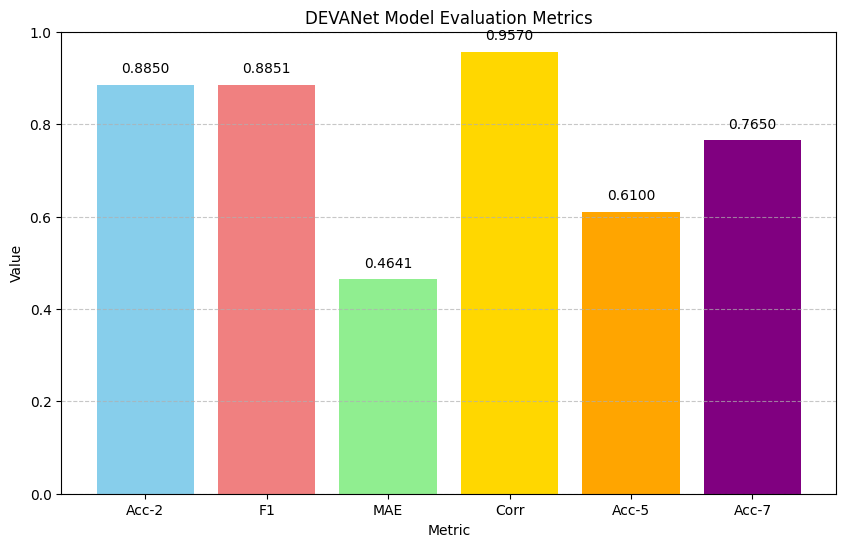

In [22]:
import matplotlib.pyplot as plt
import numpy as np

metrics_data = metrics.copy()
for key, value in metrics_data.items():
    if isinstance(value, np.float32):
        metrics_data[key] = float(value)


labels = list(metrics_data.keys())
values = list(metrics_data.values())

fig = plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orange', 'purple'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('DEVANet Model Evaluation Metrics')
plt.ylim(0, 1)

for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()